In [6]:
!pip install numpy==1.17.5;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
%tensorflow_version 1.x
!pip install tf_slim==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# For faster training time, images should be resized to 300x300 and then annotated
# Images should contain the objects of interest at various scales, angles, lighting conditions, locations
# For acceptable results - mAP@0.5 of 0.9 the model was trained with batch size of 24
# and 5000 steps. this takes about 1h using 2 augmentations. 
# using 5 augmentations it takes about 2h 
num_steps = 10000  # A step means using a single batch of data. larger batch, less steps required
#Number of evaluation steps.
num_eval_steps = 50
#Batch size 24 is a setting that generally works well. can be changed higher or lower 
MODELS_CONFIG = {
        'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 8
    }
}
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colab's GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [9]:
repo_url = 'https://github.com/luxonis/depthai-ml-training.git'
import os
%cd /content
repo_dir_path = "/content/depthai-ml-training"
!rm -rf {repo_dir_path}
!git clone {repo_url} {repo_dir_path}
%cd {repo_dir_path}
!git pull

/content
Cloning into '/content/depthai-ml-training'...
remote: Enumerating objects: 493, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 493 (delta 4), reused 4 (delta 1), pack-reused 455
Receiving objects: 100% (493/493), 100.97 MiB | 31.83 MiB/s, done.
Resolving deltas: 100% (236/236), done.
/content/depthai-ml-training
Already up to date.


In [10]:
#mount your google drive.
#it will be visible in the file navigator on the left of this notebook
#there should be a folder in your drive with your data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
#copy files from gdrive to colab drive. this takes a few minutes, depending on the number of files.
#Go on the file explorer on the left of this notebook and access your gdrive. find the folders
#with your train, test and final_test images.
#Right click on each and copy the path. paste it btw the first " " in the corresponding lines  

#training folder
!cp -r "/content/gdrive/MyDrive/obj_det_img/train" "/content/train"
#validation folder
!cp -r "/content/gdrive/MyDrive/obj_det_img/validation" "/content/validation"
#test folder
!cp -r "/content/gdrive/MyDrive/obj_det_img/test" "/content/test"


In [12]:
# quick check for training data files. you can also browse to the object_detection_demo_flows
# on the left and see if they were copied
!ls /content/train

'cot (1).jpg'  'cw (2).jpg'  'e (3).jpeg'  'mg (4).JPG'  'Rw (1).jpg'
'cot (1).xml'  'cw (2).xml'  'e (3).xml'   'mg (4).xml'  'Rw (1).xml'
'cot (5).jpg'  'cw (4).jpg'  'e (5).xml'   'mg (7).jpg'  'Rw (3).jpg'
'cot (5).xml'  'cw (4).xml'  'e (6).jpeg'  'mg (7).xml'  'Rw (3).xml'


In [13]:
# %%capture
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git
%cd /content/models/
!git checkout 58d19c67e1d30d905dd5c6e5092348658fed80af
!apt-get update && apt-get install -y -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q Cython==0.29.28 contextlib2==0.5.5 pillow==7.1.2 lxml==4.2.6 matplotlib==3.2.2
!pip uninstall -y pycocotools
!pip install --no-cache-dir pycocotools==2.0.4
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
!python object_detection/builders/model_builder_test.py

/content
/content/models
Note: checking out '58d19c67e1d30d905dd5c6e5092348658fed80af'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 58d19c67e Internal change
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 h

In [14]:
# %%capture
%cd /content/

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python depthai-ml-training/helpers/xml_to_csv.py -i /content/train/ -o /content/train_labels.csv -l /content
# Convert test folder annotation xml files to a single csv.
!python depthai-ml-training/helpers/xml_to_csv.py -i /content/validation/ -o /content/test_labels.csv

# Generate `train.record`
!python depthai-ml-training/helpers/generate_tfrecord.py --csv_input=/content/train_labels.csv --output_path=/content/train.record --img_path=/content/train --label_map label_map.pbtxt

# Generate `test.record`
!python depthai-ml-training/helpers/generate_tfrecord.py --csv_input=/content/test_labels.csv --output_path=/content/test.record --img_path=/content/validation --label_map label_map.pbtxt

# Set the paths
test_record_fname = '/content/test.record'
train_record_fname = '/content/train.record'
label_map_pbtxt_fname = '/content/label_map.pbtxt'

/content
Successfully converted xml to csv.
Generate `/content/label_map.pbtxt`
Successfully converted xml to csv.


W0711 14:19:37.366280 139830648444800 module_wrapper.py:139] From depthai-ml-training/helpers/generate_tfrecord.py:111: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0711 14:19:37.389272 139830648444800 module_wrapper.py:139] From depthai-ml-training/helpers/generate_tfrecord.py:57: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Traceback (most recent call last):
  File "depthai-ml-training/helpers/generate_tfrecord.py", line 138, in <module>
    tf.app.run()
  File "/tensorflow-1.15.2/python3.7/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 312, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 2

In [15]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research
/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 63 root   root  4.0K Jul 11 14:19 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [16]:
#TF pretrained model checkpoint
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

In [17]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [18]:
from pathlib import Path
parent = Path(label_map_pbtxt_fname).parent
!ls {parent}

depthai-ml-training  models	  test_labels.csv  train_labels.csv
gdrive		     sample_data  test.record	   train.record
label_map.pbtxt      test	  train		   validation


In [19]:
import re
iou_threshold = 0.50
num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    # Set number of classes num_classes.
    s = re.sub('iou_threshold: [0-9].[0-9]+',
               'iou_threshold: {}'.format(iou_threshold), s)
    
    f.write(s)

In [20]:
# #Have a look at the config file with various settings
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 5
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

In [21]:
model_dir = 'training/'
# Optionally remove content in output model directory for a fresh start.
# !rm -rf {model_dir}
# os.makedirs(model_dir, exist_ok=True)
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0711 14:19:48.213905 140328655116160 model_lib.py:717] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 10000
I0711 14:19:48.214154 140328655116160 config_util.py:552] Maybe overwriting train_steps: 10000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0711 14:19:48.214271 140328655116160 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0711 14:19:48.214358 140328655116160 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0711 14:19:48.214447 140328655116160 config_util.py:552] Maybe overwriting eval_num_epochs: 1
INFO:tensorflow:Maybe overwriting load_pretrained: True
I0711 14:19:48.214529 140328655116160 config_util.py:552] Maybe overwriting load_pretrained: True
INFO:tensorflow:Ignoring config override key: load_pretrained
I0711 14:19:48.214607 140328655116160 config_util.py

In [22]:
#model dir check for the trained model
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1657549208.d86b7803b2a3
export
graph.pbtxt
model.ckpt-10000.data-00000-of-00001
model.ckpt-10000.index
model.ckpt-10000.meta
model.ckpt-5780.data-00000-of-00001
model.ckpt-5780.index
model.ckpt-5780.meta
model.ckpt-6959.data-00000-of-00001
model.ckpt-6959.index
model.ckpt-6959.meta
model.ckpt-8133.data-00000-of-00001
model.ckpt-8133.index
model.ckpt-8133.meta
model.ckpt-9323.data-00000-of-00001
model.ckpt-9323.index
model.ckpt-9323.meta


In [23]:
%%capture
import re
import numpy as np

output_directory = './fine_tuned_model'
# output_directory = '/content/gdrive/My\ Drive/data/'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

In [24]:
#export directory check
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


In [25]:
import os
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)
# !ls -alh {pb_fname}

In [26]:
####  testing

import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  "/content/test"

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)




In [27]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
# This is needed to display the images.
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

/content/models/research/object_detection


In [28]:
# Visualize the results
%matplotlib inline
plt.close('all')
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  print(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=16)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

/content/validation/e (9).jpeg


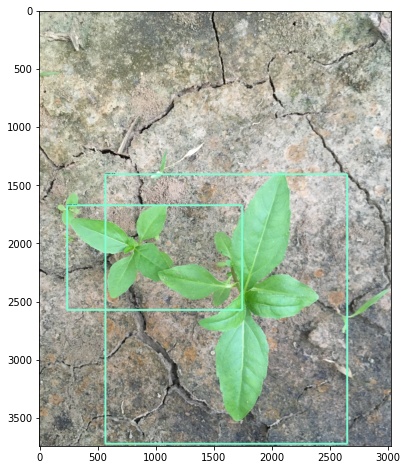

In [29]:
# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_VAL_IMAGES_DIR =  "/content/validation"

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
VAL_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_VAL_IMAGES_DIR, "*.jpeg"))
assert len(VAL_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_VAL_IMAGES_DIR)

for image_path in VAL_IMAGE_PATHS:
  image = Image.open(image_path)
  print(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  res = vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=16)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(res)
  plt.show()

  plt.imsave('/content/res.jpeg', res)

In [29]:
# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_VAL_IMAGES_DIR =  "/content/validation"

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
VAL_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_VAL_IMAGES_DIR, "*.jpg"))
assert len(VAL_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_VAL_IMAGES_DIR)

for image_path in VAL_IMAGE_PATHS:
  image = Image.open(image_path)
  print(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  res = vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=16)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(res)
  plt.show()

  plt.imsave('/content/res.jpeg', res)

/content/validation/mg (10).JPG


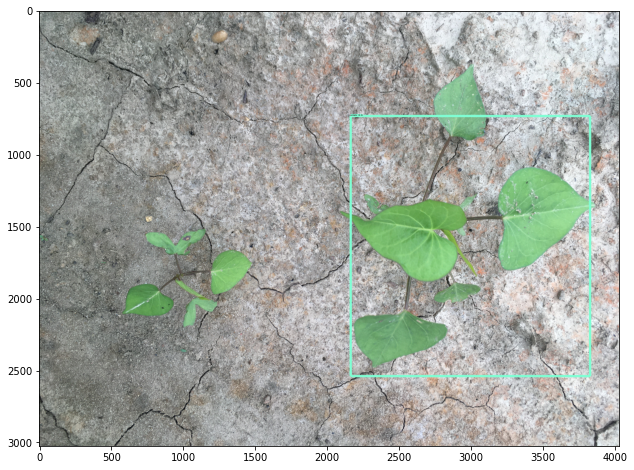

In [30]:
# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_VAL_IMAGES_DIR =  "/content/validation"

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
VAL_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_VAL_IMAGES_DIR, "*.JPG"))
assert len(VAL_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_VAL_IMAGES_DIR)

for image_path in VAL_IMAGE_PATHS:
  image = Image.open(image_path)
  print(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  res = vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=16)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(res)
  plt.show()
  
  plt.imsave('/content/res.jpeg', res)

/content/gdrive/MyDrive/obj_det_img/test2.jpg


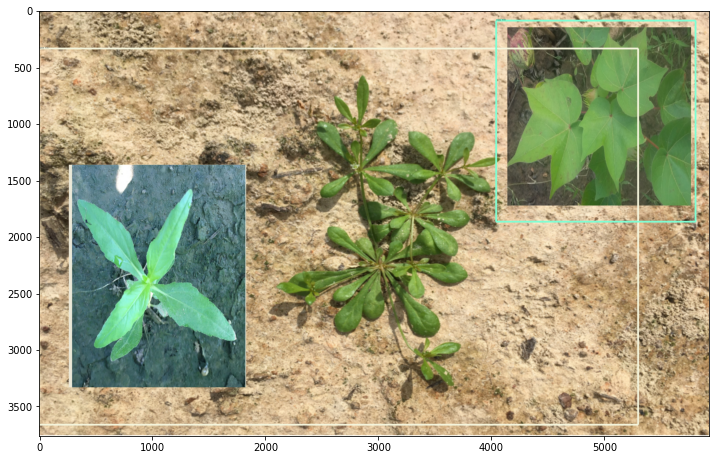

In [31]:
image_path='/content/gdrive/MyDrive/obj_det_img/test2.jpg'
image = Image.open(image_path)
print(image_path)
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np, detection_graph)
# Visualization of the results of a detection.
res = vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=16)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(res)
plt.show()

plt.imsave('/content/res.jpeg', res)